In [153]:
import torch
from torch.optim import LBFGS

from torch_kalman.kalman_filter import KalmanFilter
from torch_kalman.process import LocalLevel, LocalTrend, Season, FourierSeason, LinearModel
from torch_kalman.utils.data import TimeSeriesDataset
from torch_kalman.utils.simulate import simulate_daily_series

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 読み込み

In [154]:
import requests
from zipfile import ZipFile
from io import BytesIO
response =\
    requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip')
zip_file = ZipFile(BytesIO(response.content))
files = zip_file.namelist()
df_aq = pd.concat(
    [pd.read_csv(zip_file.open(f)) for f in files if f.endswith('csv')])
df_aq.to_csv("./PRSA2017_Data_20130301-20170228.csv", index=False)

In [155]:
df_aq.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [156]:
df_aq.shape

(420768, 18)

In [157]:
df_aq['time'] = pd.to_datetime(df_aq.loc[:,['year','month','day','hour']])
df_aq = df_aq.rename(columns={'PM2.5':'PM2p5'})

In [158]:
df_aq.head()

,No,year,month,day,hour,PM2p5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,time
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00


# weekly単位にまとめ上げる

In [159]:
df_aq_weekly = df_aq.\
    assign(date= lambda df: df['time'].astype('datetime64[D]') - pd.to_timedelta(df['time'].dt.dayofweek, unit='d')).\
    drop(columns= ['year','month','day','hour']).\
    groupby(['date','station']).\
    agg('mean').\
    reset_index().\
    sort_values(['station','date']).\
    reset_index()

In [160]:
print(df_aq_weekly.shape)
df_aq_weekly.head()

(2520, 15)


,index,date,station,No,PM2p5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,0,2013-02-25,Aotizhongxin,36.5,38.263889,57.791667,36.541667,56.750000,958.236111,37.583333,2.525000,1022.777778,-15.666667,0.000000,2.130556
1,12,2013-03-04,Aotizhongxin,156.5,139.428571,198.149701,65.280906,97.762964,2021.701220,59.529762,7.797619,1008.958929,-7.088690,0.000000,2.006548
2,24,2013-03-11,Aotizhongxin,324.5,157.071429,177.184524,57.416667,81.952381,1711.277108,65.720238,6.402976,1014.233929,-2.277976,0.017262,1.599405
3,36,2013-03-18,Aotizhongxin,492.5,67.321429,92.511905,19.750000,55.160714,1026.663793,38.795785,4.535119,1009.782738,-5.529762,0.098810,2.416667
4,48,2013-03-25,Aotizhongxin,660.5,107.333333,145.422619,41.559006,72.244048,1286.089041,29.011673,6.991071,1012.829762,-3.762500,0.000000,1.922024


In [161]:
len(df_aq_weekly['date'].unique())

210

In [162]:
len(df_aq_weekly['station'].unique())

12

# 目的変数を前処理

In [163]:
SPLIT_DT = np.datetime64('2016-02-22') 
# get means/stds for preprocessing:
col_means = df_aq_weekly.loc[df_aq_weekly['date'] < SPLIT_DT,:].mean()
col_stds = df_aq_weekly.loc[df_aq_weekly['date'] < SPLIT_DT,:].std()

# 目的変数['SO2','PM10']

In [164]:
measures = ['SO2','PM10']

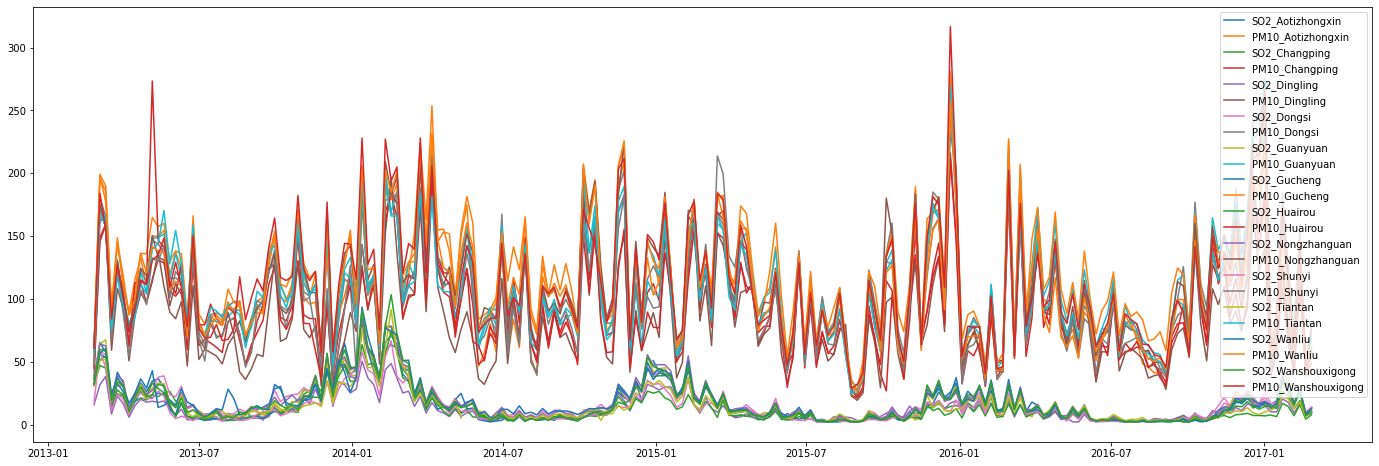

In [165]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
for station in df_aq_weekly['station'].unique():
    for col in measures:
        df_tmp = df_aq_weekly[df_aq_weekly['station'] == station]
        ax.plot(df_tmp['date'], df_tmp[col], label='{}_{}'.format(col, station))
ax.legend()

平均で割ってログをとる

In [166]:
# for training/validation split
SPLIT_DT = np.datetime64('2016-02-22') 

# get means/stds for preprocessing:
col_means = df_aq_weekly.loc[df_aq_weekly['date'] < SPLIT_DT,:].mean()
col_stds = df_aq_weekly.loc[df_aq_weekly['date'] < SPLIT_DT,:].std()

In [167]:
measures_pp = [m + '_log10_scaled' for m in measures]
df_aq_weekly[measures_pp] = np.log10(df_aq_weekly[measures] / col_means[measures])

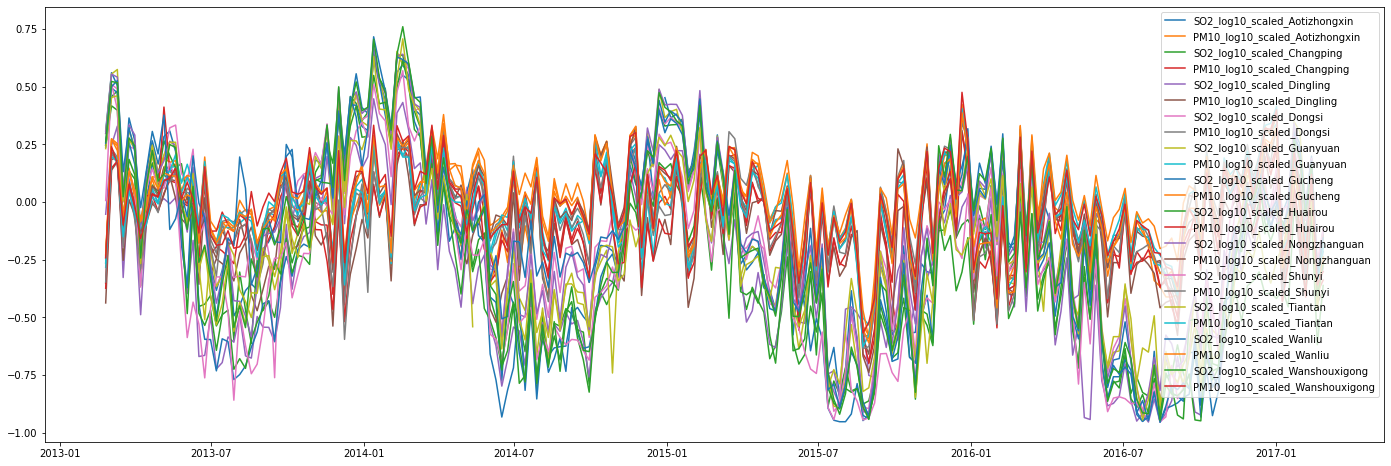

In [168]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
for station in df_aq_weekly['station'].unique():
    for col in measures_pp:
        df_tmp = df_aq_weekly[df_aq_weekly['station'] == station]
        ax.plot(df_tmp['date'], df_tmp[col], label='{}_{}'.format(col, station))
ax.legend()

# データ分割

https://github.com/strongio/torch-kalman/blob/master/torch_kalman/utils/data.py

In [169]:
df_aq_weekly

,index,date,station,No,PM2p5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,SO2_log10_scaled,PM10_log10_scaled
0,0,2013-02-25,Aotizhongxin,36.5,38.263889,57.791667,36.541667,56.750000,958.236111,37.583333,2.525000,1022.777778,-15.666667,0.000000,2.130556,0.308145,-0.263553
1,12,2013-03-04,Aotizhongxin,156.5,139.428571,198.149701,65.280906,97.762964,2021.701220,59.529762,7.797619,1008.958929,-7.088690,0.000000,2.006548,0.560143,0.271575
2,24,2013-03-11,Aotizhongxin,324.5,157.071429,177.184524,57.416667,81.952381,1711.277108,65.720238,6.402976,1014.233929,-2.277976,0.017262,1.599405,0.504395,0.223007
3,36,2013-03-18,Aotizhongxin,492.5,67.321429,92.511905,19.750000,55.160714,1026.663793,38.795785,4.535119,1009.782738,-5.529762,0.098810,2.416667,0.040924,-0.059221
4,48,2013-03-25,Aotizhongxin,660.5,107.333333,145.422619,41.559006,72.244048,1286.089041,29.011673,6.991071,1012.829762,-3.762500,0.000000,1.922024,0.364022,0.137213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2471,2017-01-30,Wanshouxigong,34428.5,112.833333,119.059524,27.666667,57.565476,1458.083832,40.898810,0.768304,1024.101984,-18.331548,0.000000,1.704167,0.187314,0.050346
2516,2483,2017-02-06,Wanshouxigong,34596.5,44.077844,61.395210,15.544910,40.502994,872.455090,49.461078,0.625298,1025.392857,-16.977381,0.000000,2.352976,-0.063055,-0.237284
2517,2495,2017-02-13,Wanshouxigong,34764.5,123.291667,139.613095,26.166667,78.571429,1661.077844,34.279762,2.870238,1019.840476,-11.551190,0.000000,1.970833,0.163105,0.119508
2518,2507,2017-02-20,Wanshouxigong,34932.5,36.289655,46.372414,7.020833,43.305556,684.027778,43.262411,3.425000,1022.414881,-11.811905,0.024405,1.903571,-0.408254,-0.359159


In [170]:
# create a dataset:
dataset_all = TimeSeriesDataset.from_dataframe(
    dataframe=df_aq_weekly,
    dt_unit='W',
    measure_colnames=measures_pp,
    group_colname='station', 
    time_colname='date'
)

# Train/Val split:
dataset_train, dataset_val = dataset_all.train_val_split(dt=SPLIT_DT)
dataset_train, dataset_val

(TimeSeriesDataset(sizes=[torch.Size([12, 156, 2])], measures=(('SO2_log10_scaled', 'PM10_log10_scaled'),)),
 TimeSeriesDataset(sizes=[torch.Size([12, 54, 2])], measures=(('SO2_log10_scaled', 'PM10_log10_scaled'),)))

# モデル作成

In [194]:
processes = []
for measure in measures_pp:
    processes.extend([
        LocalTrend(
            id=f'{measure}_trend', multi=.01
        ).add_measure(measure),
        LocalLevel(
            id=f'{measure}_local_level',
            decay=(.90,1.00)
        ).add_measure(measure),
        FourierSeason(
            id=f'{measure}_day_in_year', seasonal_period=365.25 / 7., dt_unit='W', K=2, fixed=True
        ).add_measure(measure)
    ])
kf_first = KalmanFilter(measures=measures_pp, 
                      processes=processes, 
#                    Either a np.timedelta64, or one of {'weekly','yearly','daily'}
                      measure_var_predict=('seasonal',dict(K=2,period='yearly',dt_unit='W')))

In [195]:
processes

[LocalTrend(id='SO2_log10_scaled_trend'),
 LocalLevel(id='SO2_log10_scaled_local_level'),
 FourierSeason(id='SO2_log10_scaled_day_in_year'),
 LocalTrend(id='PM10_log10_scaled_trend'),
 LocalLevel(id='PM10_log10_scaled_local_level'),
 FourierSeason(id='PM10_log10_scaled_day_in_year')]

In [196]:
kf_first

KalmanFilter(
  (design_parameters): ModuleDict(
    (process:SO2_log10_scaled_trend): ParameterDict(  (velocity): Parameter containing: [torch.FloatTensor of size 1])
    (process:SO2_log10_scaled_local_level): ParameterDict(  (decay): Parameter containing: [torch.FloatTensor of size 1])
    (process:SO2_log10_scaled_day_in_year): ParameterDict()
    (process:PM10_log10_scaled_trend): ParameterDict(  (velocity): Parameter containing: [torch.FloatTensor of size 1])
    (process:PM10_log10_scaled_local_level): ParameterDict(  (decay): Parameter containing: [torch.FloatTensor of size 1])
    (process:PM10_log10_scaled_day_in_year): ParameterDict()
    (measure_cov): ParameterDict(
        (cholesky_log_diag): Parameter containing: [torch.FloatTensor of size 2]
        (cholesky_off_diag): Parameter containing: [torch.FloatTensor of size 1]
    )
    (measure_var_nn): ModuleList(
      (0): FourierSeasonNN(in_features=4, out_features=2, bias=False)
    )
    (init_state): ParameterDict(
 

# 学習

In [197]:
kf_first.opt = LBFGS(kf_first.parameters(), lr=.20, max_eval=10)

def closure():
    kf_first.opt.zero_grad()
    pred = kf_first(
        dataset_train.tensors[0], 
        start_datetimes=dataset_train.start_datetimes, 
    )
    loss = -pred.log_prob(dataset_train.tensors[0]).mean()
    loss.backward()
    return loss

for epoch in range(15):
    train_loss = kf_first.opt.step(closure).item()
    with torch.no_grad():
        pred = kf_first(
            dataset_val.tensors[0], 
            start_datetimes=dataset_val.start_datetimes
        )
        val_loss = -pred.log_prob(dataset_val.tensors[0]).mean().item()
    print(f"EPOCH {epoch}, TRAIN LOSS {train_loss}, VAL LOSS {val_loss}")


EPOCH 0, TRAIN LOSS 2.3362948894500732, VAL LOSS 5.598145008087158
EPOCH 1, TRAIN LOSS 4.288256645202637, VAL LOSS -0.2815719544887543
EPOCH 2, TRAIN LOSS -0.41534343361854553, VAL LOSS -0.5575322508811951
EPOCH 3, TRAIN LOSS -0.5981056690216064, VAL LOSS -0.6274031400680542
EPOCH 4, TRAIN LOSS -0.7190855145454407, VAL LOSS -0.6182633638381958
EPOCH 5, TRAIN LOSS -0.7288836240768433, VAL LOSS -0.6306321620941162
EPOCH 6, TRAIN LOSS -0.7461827397346497, VAL LOSS -0.6671942472457886
EPOCH 7, TRAIN LOSS -0.7555162906646729, VAL LOSS -0.736446738243103
EPOCH 8, TRAIN LOSS -0.7776552438735962, VAL LOSS -0.7706443667411804
EPOCH 9, TRAIN LOSS -0.8209282755851746, VAL LOSS -0.7895634770393372
EPOCH 10, TRAIN LOSS -0.8441121578216553, VAL LOSS -0.8125081062316895
EPOCH 11, TRAIN LOSS -0.8551972508430481, VAL LOSS -0.7408661246299744
EPOCH 12, TRAIN LOSS -0.8747175931930542, VAL LOSS -0.6910638809204102
EPOCH 13, TRAIN LOSS -0.88660728931427, VAL LOSS -0.6981588006019592
EPOCH 14, TRAIN LOSS -0

# 可視化

In [198]:
dataset_train.tensors[0].shape[1]

156

In [199]:
pred = kf_first(
    dataset_train.tensors[0], 
    start_datetimes=dataset_train.start_datetimes,
    out_timesteps=dataset_all.tensors[0].shape[1]
)

In [200]:
def inverse_transform(df: pd.DataFrame, col_means: pd.Series) -> pd.DataFrame:
    df = df.copy()
    df['measure'] = df['measure'].str.replace('_log10_scaled','')
    std = (df['upper'] - df['lower']) / 1.96
    for col in ['mean','lower','upper','actual']:
        if col == 'mean':
            # bias correction:
            df[col] = df[col] + .5 * std ** 2
        df[col] = 10 ** df[col] # inverse log10
        df[col] *= df['measure'].map(col_means.to_dict()) # inverse scaling
    return df

pred = kf_first(
    dataset_train.tensors[0], 
    start_datetimes=dataset_train.start_datetimes,
    out_timesteps=dataset_all.tensors[0].shape[1]
)

df_pred = inverse_transform(pred.to_dataframe(dataset_all), col_means)
df_pred.head()

,actual,group,lower,mean,measure,time,upper
0,36.541666,Aotizhongxin,20.563219,48.939000,SO2,2013-02-25,90.774997
1,65.280905,Aotizhongxin,19.189254,46.290600,SO2,2013-03-04,86.438769
2,57.416664,Aotizhongxin,18.161056,44.326629,SO2,2013-03-11,83.248040
3,19.750001,Aotizhongxin,17.081740,42.172348,SO2,2013-03-18,79.643804
4,41.559007,Aotizhongxin,13.913504,34.760835,SO2,2013-03-25,66.023328


In [201]:
df_aq_weekly.head()

,index,date,station,No,PM2p5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,SO2_log10_scaled,PM10_log10_scaled
0,0,2013-02-25,Aotizhongxin,36.5,38.263889,57.791667,36.541667,56.750000,958.236111,37.583333,2.525000,1022.777778,-15.666667,0.000000,2.130556,0.308145,-0.263553
1,12,2013-03-04,Aotizhongxin,156.5,139.428571,198.149701,65.280906,97.762964,2021.701220,59.529762,7.797619,1008.958929,-7.088690,0.000000,2.006548,0.560143,0.271575
2,24,2013-03-11,Aotizhongxin,324.5,157.071429,177.184524,57.416667,81.952381,1711.277108,65.720238,6.402976,1014.233929,-2.277976,0.017262,1.599405,0.504395,0.223007
3,36,2013-03-18,Aotizhongxin,492.5,67.321429,92.511905,19.750000,55.160714,1026.663793,38.795785,4.535119,1009.782738,-5.529762,0.098810,2.416667,0.040924,-0.059221
4,48,2013-03-25,Aotizhongxin,660.5,107.333333,145.422619,41.559006,72.244048,1286.089041,29.011673,6.991071,1012.829762,-3.762500,0.000000,1.922024,0.364022,0.137213


In [202]:
pred

GaussianOverTime(num_groups=12, num_timesteps=210)

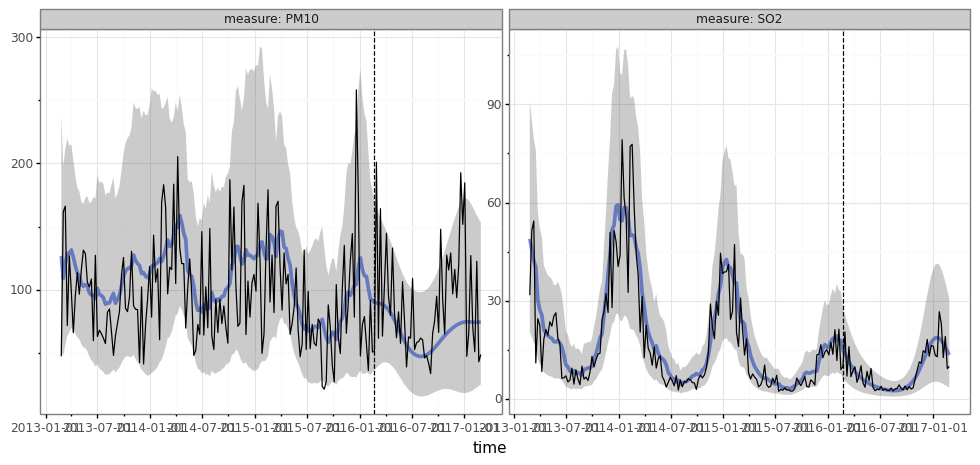

<ggplot: (-9223372036523765465)>


In [203]:
# Changping駅のみ
print(pred.plot(df_pred.query("group=='Changping'"), split_dt=SPLIT_DT))

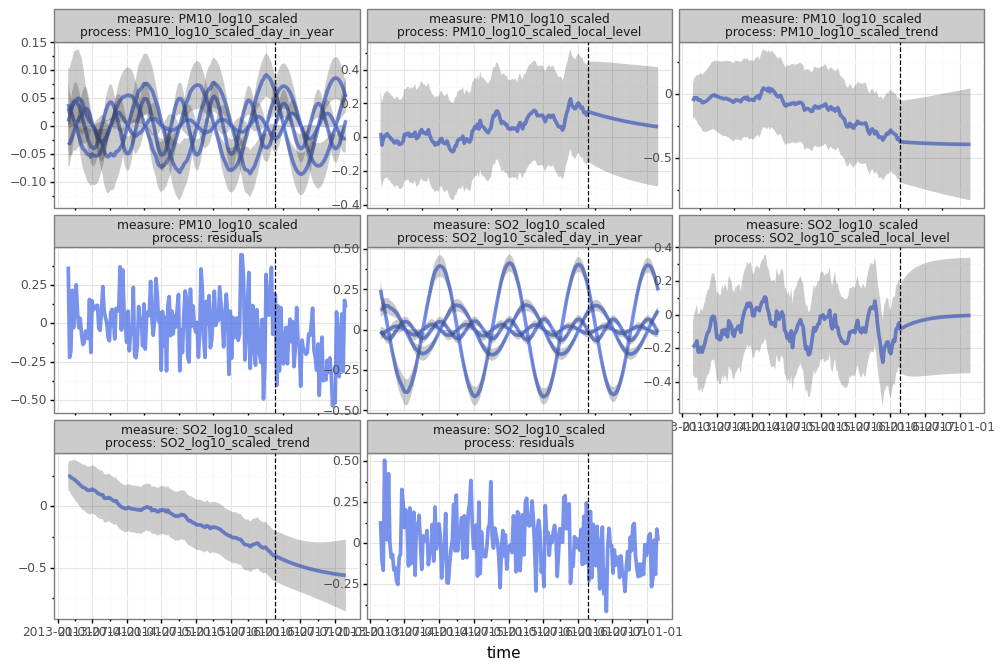

<ggplot: (-9223372036514424772)>


In [204]:
print(pred.plot(pred.to_dataframe(dataset_all, type='components').query("group=='Changping'"), split_dt=SPLIT_DT))


In [206]:
pred.to_dataframe(dataset_all, type='components').query("group=='Changping'")

,group,lower,mean,measure,process,state_element,time,upper
0,Changping,0.131934,0.241684,SO2_log10_scaled,SO2_log10_scaled_trend,position,2013-02-25,0.351433
1,Changping,0.122566,0.245981,SO2_log10_scaled,SO2_log10_scaled_trend,position,2013-03-04,0.369396
2,Changping,0.100388,0.235625,SO2_log10_scaled,SO2_log10_scaled_trend,position,2013-03-11,0.370861
3,Changping,0.083259,0.228497,SO2_log10_scaled,SO2_log10_scaled_trend,position,2013-03-18,0.373735
4,Changping,0.068683,0.222347,SO2_log10_scaled,SO2_log10_scaled_trend,position,2013-03-25,0.376011
...,...,...,...,...,...,...,...,...
205,Changping,NaN,-0.081011,PM10_log10_scaled,residuals,residuals,2017-01-30,NaN
206,Changping,NaN,0.062273,PM10_log10_scaled,residuals,residuals,2017-02-06,NaN
207,Changping,NaN,-0.312575,PM10_log10_scaled,residuals,residuals,2017-02-13,NaN
208,Changping,NaN,0.150994,PM10_log10_scaled,residuals,residuals,2017-02-20,NaN
